# Modules, colors, and functions

### Remove scroll from figures

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Extend the size of the Window

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Load Modules

In [5]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import convolution as conv
from astropy.time import Time
import datetime
import glob
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from pprint import pprint
import scipy as sp
from scipy.interpolate import griddata
from scipy import sparse, signal, stats
import scipy.ndimage.morphology as morph
import sunpy.cm as cm
import sunpy.map
import sunpy.physics.differential_rotation as dr
import torch.nn.functional as F

import sys, os

os.environ["CUDA_VISIBLE_DEVICES"]=""

sys.path.append("../../../")
from source.pipeline.model_manager import BaseScaler
from source.pipeline.models.highresnet import HighResNet
from source.pipeline.models.highresnet_rprc import HighResNet_RPRC
from source.pipeline.models.highresnet_rprcdo import HighResNet_RPRCDO
from source.pipeline.losses.baseline_loss import MSELoss, L1Loss
from source.pipeline.entropy import Entropy

from source.pipeline.metrics_denoised_hist import DenoisedHistogram
from source.pipeline.metrics import *

from source.patch_stitch import get_patch
from source.patch_stitch import get_img_from_patch
from source.multiframe import register
from source.prep import scale_rotate

from skimage.transform import resize

from reproject import reproject_exact, reproject_interp #use reproject_interp if you want it done quicker.

import torch
import torch.nn as nn
import yaml

%matplotlib inline

### Load and interface with Google Cloud Storage

In [6]:
# Imports the Google Cloud client library
from google.cloud import storage

# Instantiates a client
client = storage.Client()

### Remove Warnings and Define Color Defaults

You can switch colormaps between *hmimag* (*seismic*) if you want to focus on the *weak* (*strong*) magnetic features.

In [7]:
# Remove Warnings
# import warnings
# warnings.filterwarnings('ignore')

# Color Axis limits
vmin = -2000
vmax = 2000

# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Colormap Definition
current_cmap = plt.cm.get_cmap('hmimag')
# current_cmap = plt.cm.get_cmap('seismic')
current_cmap.set_bad(color='black')

device = torch.device('cpu')

## Load mHarp mask

In [114]:
HMI_harpf = fits.open('/home/andres_munoz_j/mharps/2011/04/hmi.Mharp_720s.451.20110401_000000_TAI.bitmap.fits')
HMI_harpf.verify('fix')

# HMI_harp = sunpy.map.Map(HMI_harpf[1].data, HMI_harpf[1].header)
HMI_harpb = sunpy.map.Map(HMI_harpf[0].data, HMI_harpf[0].header)

In [115]:
np.histogram(HMI_harpm.data, bins=np.arange(-1,3)+0.5)

(array([ 5378438, 11198043,    58901]), array([-0.5,  0.5,  1.5,  2.5]))

In [116]:
np.histogram(HMI_harpb.data, bins=np.arange(-1,36)+0.5)

(array([     0, 125009,    941,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0, 124563,  17271,      0]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5,
        21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5,
        32.5, 33.5, 34.5, 35.5]))

In [117]:
index = np.column_stack(np.where(HMI_harpb.data>10))

In [118]:
# HMI_harpb.data[index[:,0],index[:,1]] = 10

In [119]:
np.histogram(HMI_harpb.data, bins=np.arange(-1,36)+0.5)

(array([     0, 125009,    941,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0, 124563,  17271,      0]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5,
        21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5,
        32.5, 33.5, 34.5, 35.5]))

Text(0.99, 0.99, 'A')

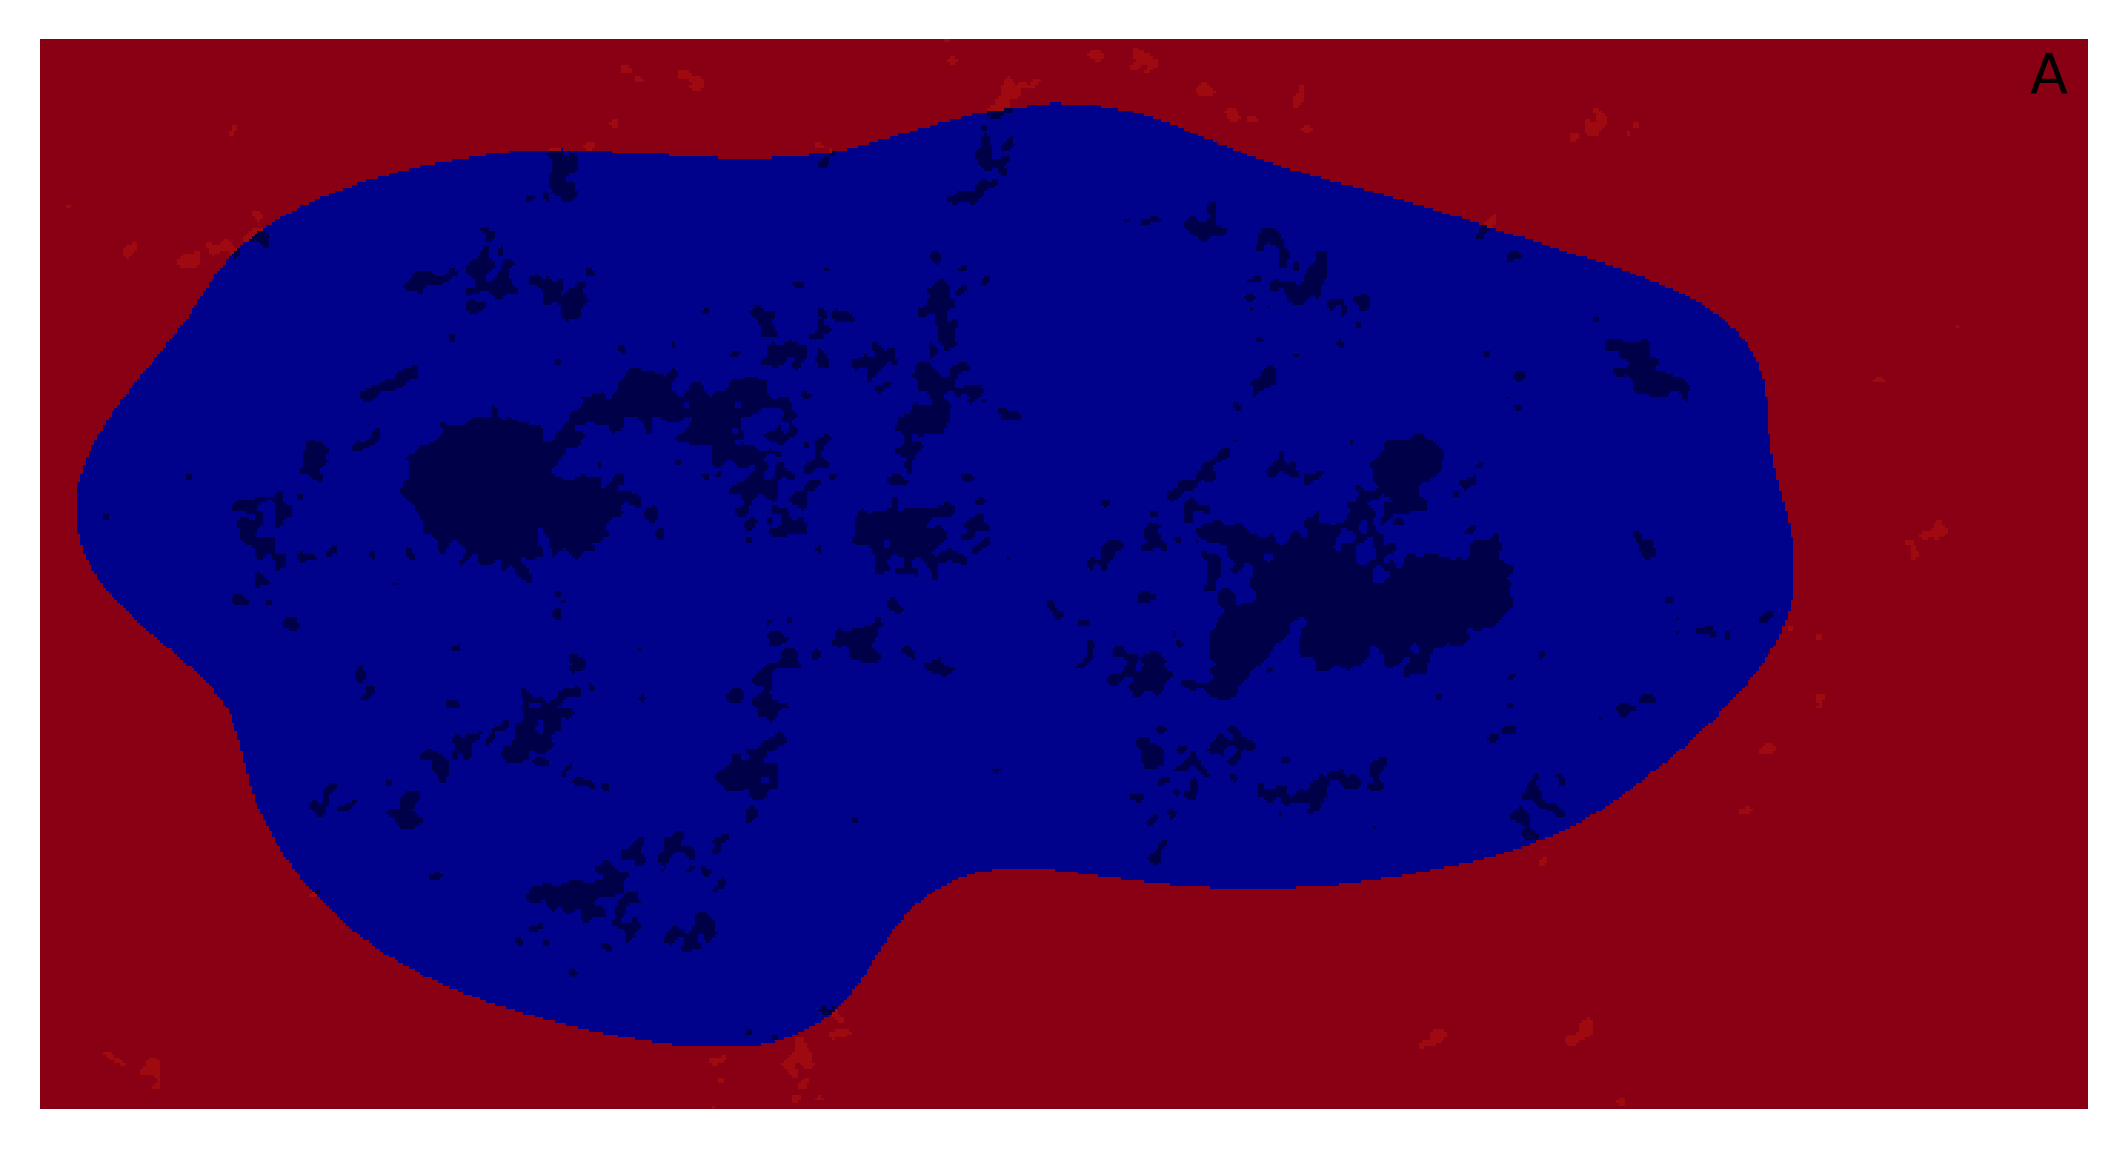

In [120]:

dy = 0
dx = 0

# Polar Crown Extent
PCrownLat = 60*u.deg

# Size definitions
dpi = 400
pxx = 2048   # Horizontal size of each panel
pxy = 2048   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)


# Inferred
ax1 = fig.add_axes([ppadh, ppadv+ppxy, ppxx, ppxy])
ax1.imshow(HMI_harpb.data, cmap = current_cmap, origin='lower')
ax1.set_axis_off()
# ax1.text(0.99, 0.99, 'Using prepped data ', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes, fontsize=10*(scale_factor/real_scale_factor))
ax1.text(0.99, 0.99, 'A', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes, fontsize=10)

# fig.savefig('Model_A.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

In [121]:
HMI_harpb.meta

MetaDict([('simple', True),
          ('bitpix', 16),
          ('naxis', 2),
          ('naxis1', 716),
          ('naxis2', 374),
          ('extend', True),
          ('comment',
             FITS (Flexible Image Transport System) format is defined in 'Astronomy
             and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H),
          ('date', '2012-04-19T19:26:04'),
          ('telescop', 'SDO/HMI'),
          ('instrume', 'HMI_SIDE1'),
          ('wavelnth', 6173.0),
          ('camera', 1),
          ('bunit', 'none'),
          ('content', 'HMI Active Region Patch'),
          ('bld_vers', 'V6R1X'),
          ('quality', 0),
          ('quallev1', 0),
          ('t_obs', '2011.03.31_23:59:60_TAI'),
          ('t_rec', '2011.04.01_00:00:00_TAI'),
          ('trecepoc', '1993.01.01_00:00:00_TAI'),
          ('trecstep', 720.0),
          ('trecunit', 'secs'),
          ('cadence', 720.0),
          ('datasign', 1),
          ('harpnum', 451),
          ('date-

In [123]:
HMI_harpf = fits.open('/home/andres_munoz_j/mharps/2011/04/hmi.Mharp_720s.451.20110401_000000_TAI.mask.fits')
# HMI_harpf = fits.open('/home/andres_munoz_j/mharps/2011/04/hmi.Mharp_720s.444.20110401_000000_TAI.bitmap.fits')
# HMI_harpf = fits.open('/home/andres_munoz_j/mharps/2011/04/hmi.Mharp_720s.438.20110401_000000_TAI.magnetogram.fits')
HMI_harpf.verify('fix')

# HMI_harp = sunpy.map.Map(HMI_harpf[1].data, HMI_harpf[1].header)
HMI_harpm = sunpy.map.Map(HMI_harpf[0].data, HMI_harpf[0].header)

HMI_harpm.data[index[:,0]+int(HMI_harpm.meta['crpix2']),index[:,1]+int(HMI_harpm.meta['crpix1'])] += 3

Text(0.99, 0.99, 'A')

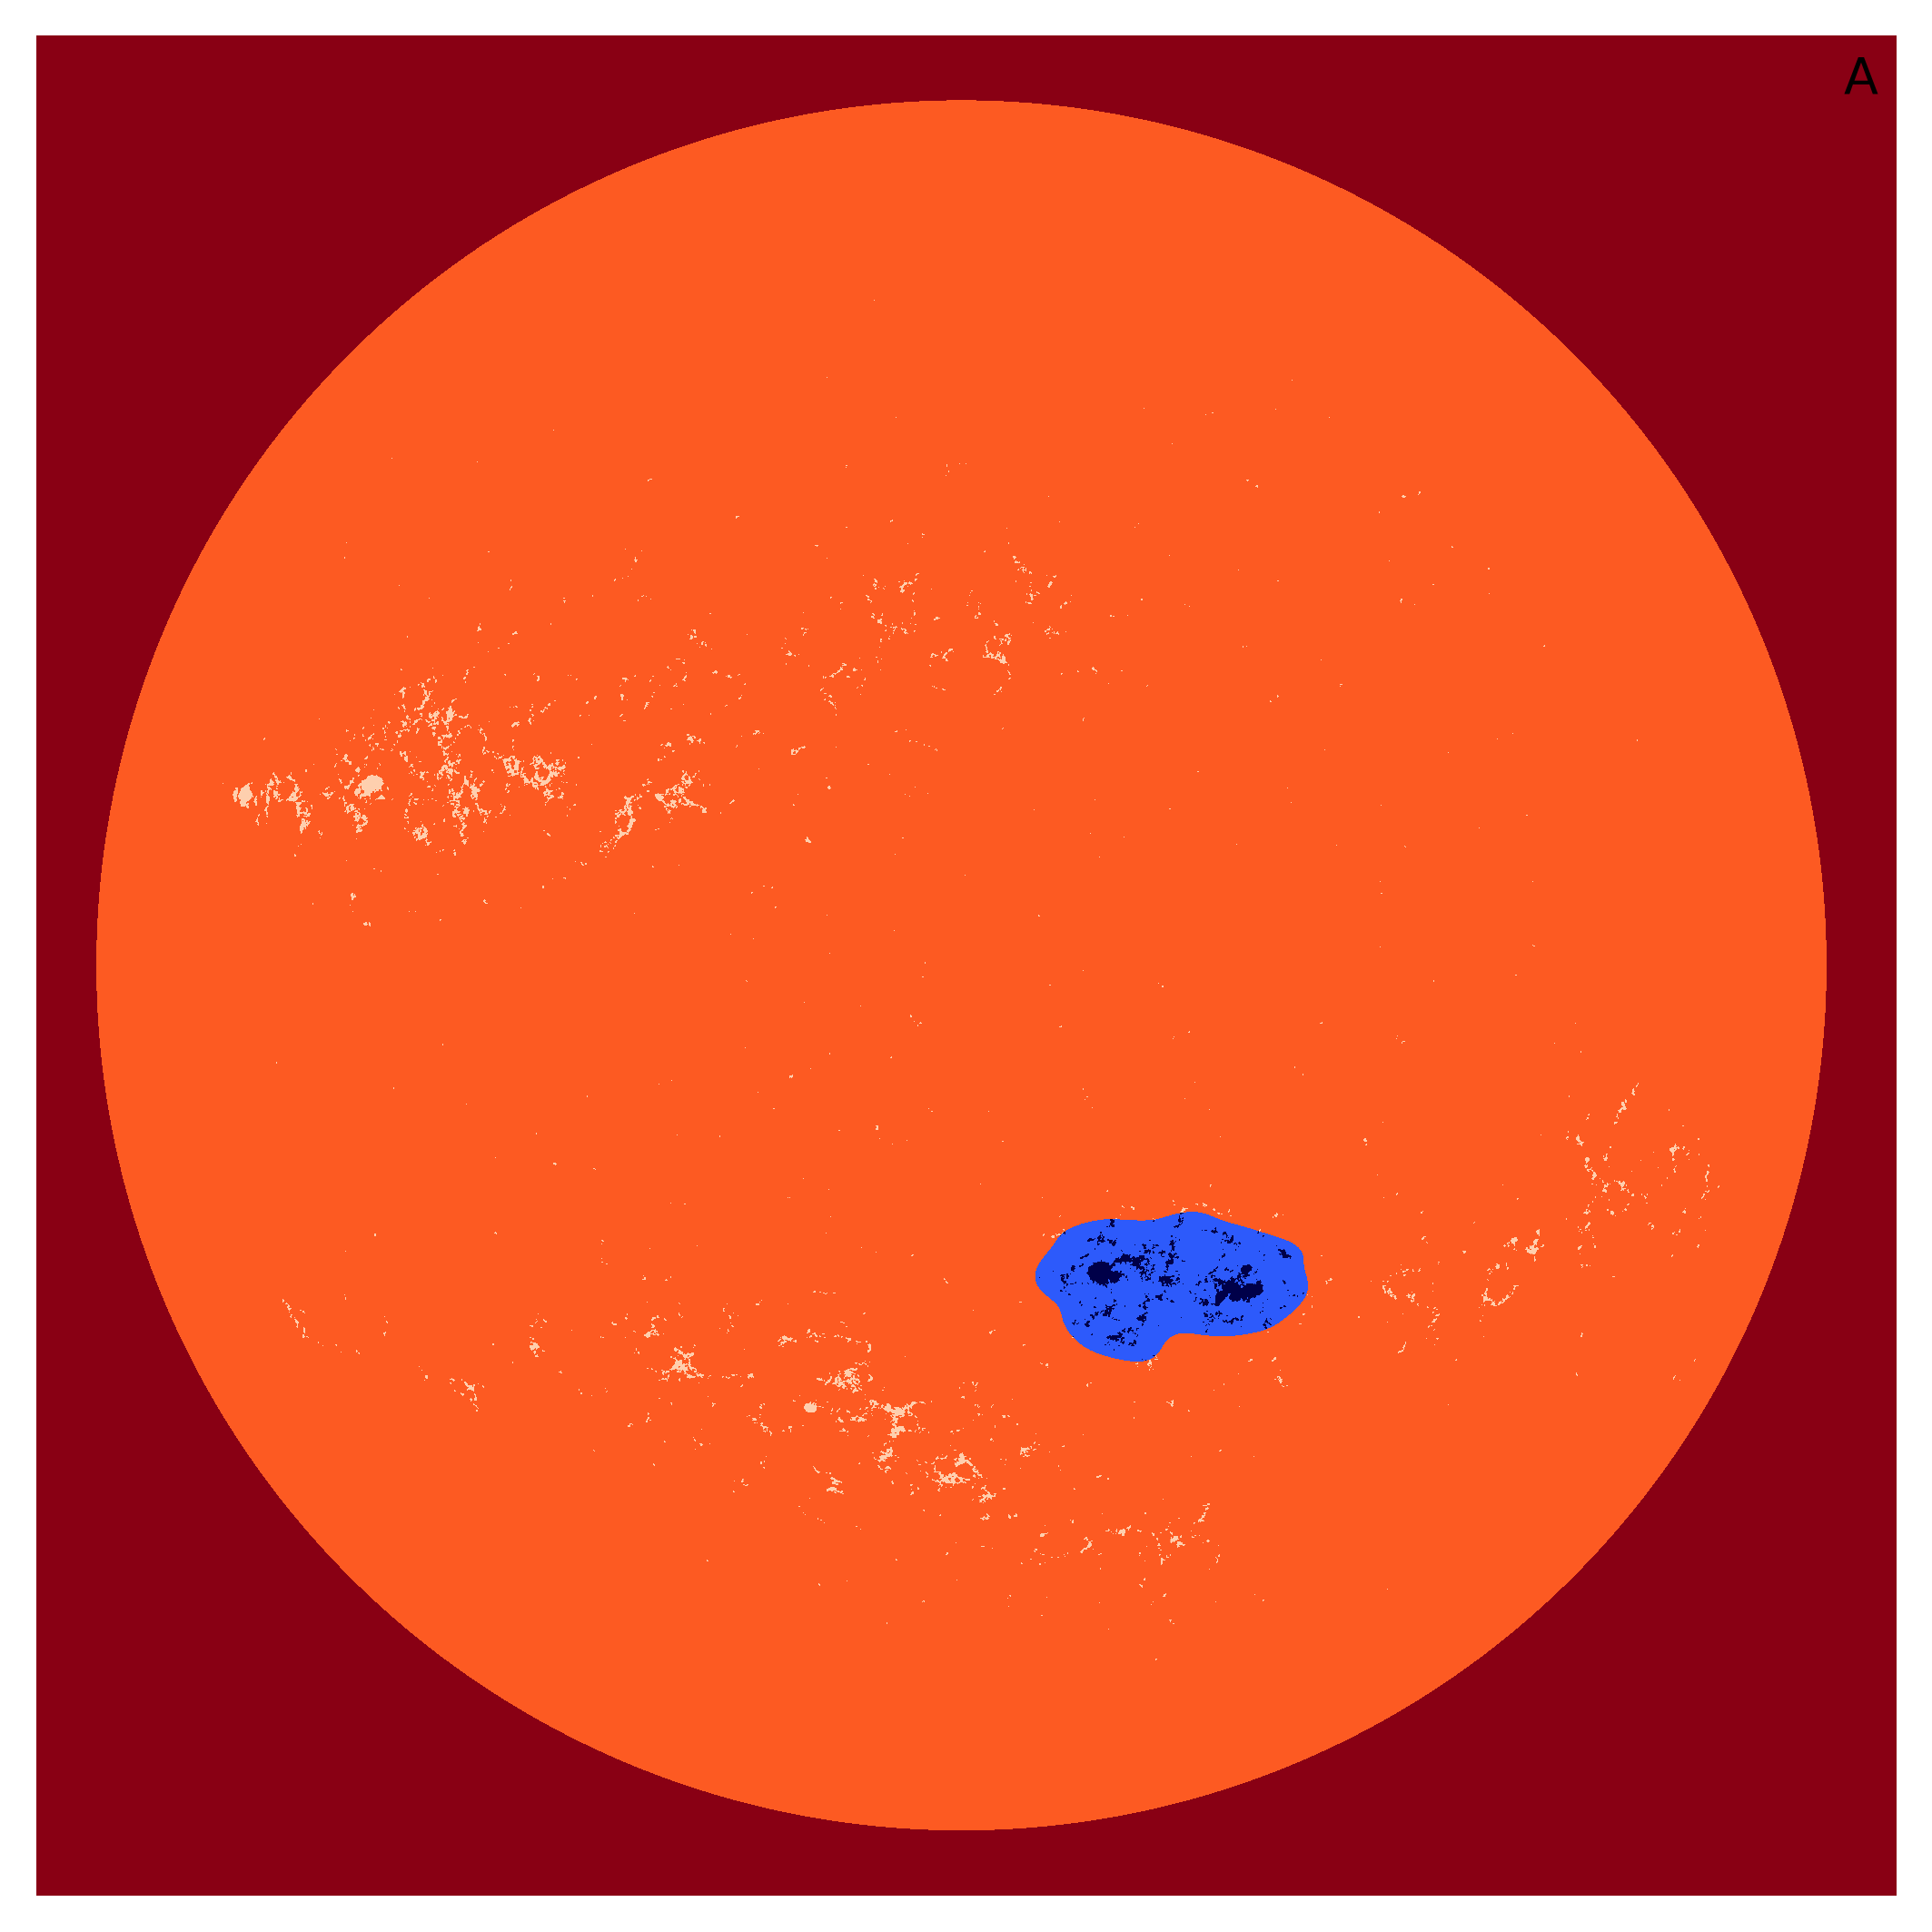

In [124]:

dy = 0
dx = 0

# Polar Crown Extent
PCrownLat = 60*u.deg

# Size definitions
dpi = 400
pxx = 2048   # Horizontal size of each panel
pxy = 2048   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)


# Inferred
ax1 = fig.add_axes([ppadh, ppadv+ppxy, ppxx, ppxy])
ax1.imshow(HMI_harpm.data, cmap = current_cmap, origin='lower')
ax1.set_axis_off()
# ax1.text(0.99, 0.99, 'Using prepped data ', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes, fontsize=10*(scale_factor/real_scale_factor))
ax1.text(0.99, 0.99, 'A', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes, fontsize=10)

# fig.savefig('Model_A.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

## Load model and checkpoint

In [93]:


# # # # ## SSIM + Hist + Grad low Grad
run = 'to-ml-mdi-new_20200501145532_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_dropout_jsoc'
epoch = 'epoch_18'
config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_highresnet_RPRC_SSIMGradhist_temp_G5_jsoc.yml'
labelJ = 'SSIM_Hist_Grad_low_jsoc'


bucket = client.bucket('fdl-mag-experiments')
blob = bucket.blob('checkpoints/' + run + '/' + epoch)
file = blob.download_to_filename('/tmp/checkpoint')


# Load config
with open(config_path, 'r') as stream:
    config_data = yaml.load(stream, Loader=yaml.SafeLoader)

# Set cuda to False as in config is true
config_data['cuda_device'] = False
print(config_data)    
    
# Create HighResnet
model = BaseScaler.from_dict(config_data)

#Load checkpoint to cpu
device = torch.device("cpu")
checkpoint = torch.load('/tmp/checkpoint', map_location=device)

#remove extra layaer from dict due to multi CPU traing
state_dict={}
for key, value in checkpoint['model_state_dict'].items():
#     print(np.append(['module'], key.split('.')[0:]))
    new_key = '.'.join(key.split('.')[1:])
    state_dict[new_key] = value
# state_dict=checkpoint['model_state_dict']

model.net.load_state_dict(state_dict)
model

{'cuda_device': False, 'data': {'data_bucket': '/mdi-hmi', 'data_folder': 'to-ml-mdi-new', 'normalisation': 3500.0}, 'net': {'name': 'HighResNet_RPRCDO', 'upscale_factor': 4, 'n_frames': 1, 'p': 0.0}, 'loss': {'name': 'SSIMGradHistLoss', 'dl': 0.15, 'noise_level': 60, 'lim': 5000, 'coeff_hist': 1e-05, 'coeff_grad': 5, 'coeff_ssim': 5e-05}, 'learning_rate': 0.0001, 'beta1': 0.5, 'batch_size': 64, 'is_gradient': True, 'nepochs': 20, 'comment': 'SSIMGradHistLoss_dropout_jsoc_rp'}
2021-01-08 - 00:02:39 INFO source.pipeline.model_manager: SSIMGradHistLoss(
  (ssim_loss): SSIM()
  (mseloss): MSELoss()
  (Hist): DenoisedHistogram(
    (conv1): Conv2d(1, 37, kernel_size=(1, 1), stride=(1, 1))
    (conv2): Conv2d(37, 37, kernel_size=(1, 1), stride=(1, 1))
  )
)


In [7]:
model.net

HighResNet_RPRCDO(
  (encode): Encoder(
    (init_layer): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): Dropout(p=0.0)
      (3): PReLU(num_parameters=1)
    )
    (res_layers): Sequential(
      (0): ResidualBlock(
        (block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (2): PReLU(num_parameters=1)
          (3): ReflectionPad2d((1, 1, 1, 1))
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): Dropout(p=0.0)
          (6): PReLU(num_parameters=1)
        )
      )
      (1): ResidualBlock(
        (block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (2): PReLU(num_parameters=1)
          (3): ReflectionPad2d((1, 1, 1, 1))
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): Dr

## Load Unprepped MDI magnetogram



In [8]:
# MDI_fitsR = fits.open('/scratch/mdi/raw/2011/01/01/mdi.fd_M_96m_lev182.20110101_000000_TAI.data.fits', cache=False)
# MDI_fitsR = fits.open('/scratch/mdi/raw/2011/01/11/mdi.fd_M_96m_lev182.20110111_222400_TAI.data.fits', cache=False)
MDI_fitsR = fits.open('/scratch/mdi/raw/2011/03/12/mdi.fd_M_96m_lev182.20110312_000000_TAI.data.fits', cache=False)
MDI_fitsR.verify('fix')

MDImapR = sunpy.map.Map(MDI_fitsR[1].data, MDI_fitsR[1].header)
MDI_fitsR.close()

x, y = np.meshgrid(*[np.arange(v.value) for v in MDImapR.dimensions]) * u.pixel
hpc_coords = MDImapR.pixel_to_world(x, y)
rSunR = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / MDImapR.rsun_obs

# Mask data and rSun array to be on disk only
MDImapR.data[rSunR>1] = 0

# patchesMDI = get_patch(MDImap, 128, instrument='MDI', target_scale=0.504273, stride=128)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/mdi/raw/2011/03/12/mdi.fd_M_96m_lev182.20110312_000000_TAI.data.fits'

In [ ]:
MDImapR.wcs

In [ ]:
scale_factor = 4

MDI_fits = fits.open('/scratch/mdi/raw/2011/03/12/mdi.fd_M_96m_lev182.20110312_000000_TAI.data.fits', cache=False)
MDI_fits.verify('fix')


MDImap = sunpy.map.Map(MDI_fits[1].data, MDI_fits[1].header)
MDI_fits.close()


# Pad image, if necessary
target_shape = int(4096)

# Reform map to new size if original shape is too small


new_fov = np.zeros((target_shape, target_shape)) * np.nan
new_meta = MDImap.meta

new_meta['crpix1'] = new_meta['crpix1'] - MDImap.data.shape[0] / 2 + new_fov.shape[0] / 2
new_meta['crpix2'] = new_meta['crpix2'] - MDImap.data.shape[1] / 2 + new_fov.shape[1] / 2

# Identify the indices for appending the map original FoV
i1 = int(new_fov.shape[0] / 2 - MDImap.data.shape[0] / 2)
i2 = int(new_fov.shape[0] / 2 + MDImap.data.shape[0] / 2)

# Insert original image in new field of view
new_fov[i1:i2, i1:i2] = MDImap.data[:, :]

# Assemble Sunpy map
MDImap = sunpy.map.Map(new_fov, new_meta)
MDImap = MDImap.rotate(scale=scale_factor, recenter=True)


# # Crop HMI image to desired shape
sz_x_diff = (MDImap.data.shape[0]-target_shape)//2
sz_y_diff = (MDImap.data.shape[0]-target_shape)//2

print(MDImap.meta['crpix1'])
print(MDImap.meta['crpix2'])

MDImap.meta['crpix1'] = MDImap.meta['crpix1']-sz_x_diff
MDImap.meta['crpix2'] = MDImap.meta['crpix2']-sz_y_diff

MDImap = sunpy.map.Map(MDImap.data[sz_x_diff:sz_x_diff+target_shape, sz_y_diff:sz_y_diff+target_shape].copy(), MDImap.meta)

x, y = np.meshgrid(*[np.arange(v.value) for v in MDImap.dimensions]) * u.pixel
hpc_coords = MDImap.pixel_to_world(x, y)
rSun = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / MDImap.rsun_obs
MDImap.data[rSun>1] = 0

## Load Target HMI magnetogram

In [ ]:
# HMI_fits = fits.open('/scratch/hmi/prep_c/2011/1/1/HMI_20110101-001010.fits', cache=False)
HMI_fits = fits.open('/scratch2/hmi/raw/2011/2011/03/12/hmi.M_720s.20110312_000000_TAI.1.magnetogram.fits', cache=False)
HMI_fits.verify('fix')

# Upscale factors
real_scale_factor = HMI_fits[1].data.shape[0]/MDI_fitsR[1].data.shape[0]
scale_factor = config_data['net']['upscale_factor']

HMI_data = HMI_fits[1].data
new_meta = HMI_fits[1].header
HMImap_HR = sunpy.map.Map(HMI_data, new_meta)
suffix = ''


HMImap = sunpy.map.Map(HMI_data, new_meta)
HMI_fits.close()
HMImap = HMImap.rotate(recenter=True)

x, y = np.meshgrid(*[np.arange(v.value) for v in HMImap.dimensions]) * u.pixel
hpc_coords = HMImap.pixel_to_world(x, y)
rSunH = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / HMImap.rsun_obs

# Mask data and rSun array to be on disk only
HMImap.data[rSunH>1] = 0



output, footprint = reproject_interp(HMImap, MDImap.wcs, MDImap.data.shape)
HMImap = sunpy.map.Map(output, MDImap.wcs)

## Full disk inference MDI-HMI Straight - Unprepped

In [ ]:
# Load data into correct format and normalise
in_fd = np.stack([MDImapR.data/config_data['data']['normalisation'], rSunR], axis=0)
in_fd = in_fd[None]

# Transform to tensor and send to CPU
in_fd_t = torch.from_numpy(in_fd).to(device).float()

# Set model to eval mode and run FD inference
scale_factor = config_data['net']['upscale_factor']


new_meta = MDImapR.meta.copy()

print(new_meta['crpix1'] - MDImapR.data.shape[0] / 2)
print(new_meta['crpix2'] - MDImapR.data.shape[1] / 2)


new_meta['crpix1'] = (new_meta['crpix1'] - MDImapR.data.shape[0] / 2 - 0.5)*scale_factor + MDImapR.data.shape[0]*scale_factor / 2 + 0.5
new_meta['crpix2'] = (new_meta['crpix2'] - MDImapR.data.shape[1] / 2 - 0.5)*scale_factor + MDImapR.data.shape[1]*scale_factor / 2 + 0.5
new_meta['cdelt1'] = new_meta['cdelt1'] / scale_factor
new_meta['cdelt2'] = new_meta['cdelt2'] / scale_factor


inferred_mapJR = sunpy.map.Map(model.forward(in_fd_t).detach().numpy()[0,...]*config_data['data']['normalisation'], new_meta)
x, y = np.meshgrid(*[np.arange(v.value) for v in inferred_mapJR.dimensions]) * u.pixel
hpc_coords = inferred_mapJR.pixel_to_world(x, y)
rSunIR = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / inferred_mapJR.rsun_obs

inferred_mapJR.data[rSunIR>1] = 0

noise = np.random.normal(loc=0.0, scale=4, size=inferred_mapJR.data.shape)
np.min(noise)
noise[rSunIR>1] = 0

## Load reprojected model and checkpoint

In [ ]:


# # # # ## SSIM + Hist + Grad low Grad
run = 'to-ml-reproject_20201017075415_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_DO_jsoc_RP'
epoch = 'epoch_19'
config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_HR_RPRC_SSIMGradhist_G5_jsoc_RP.yml'
labelJ = 'SSIM_Hist_Grad_low_jsoc'


bucket = client.bucket('fdl-mag-experiments')
blob = bucket.blob('checkpoints/' + run + '/' + epoch)
file = blob.download_to_filename('/tmp/checkpoint')


# Load config
with open(config_path, 'r') as stream:
    config_data = yaml.load(stream, Loader=yaml.SafeLoader)

# Set cuda to False as in config is true
config_data['cuda_device'] = False
print(config_data)    
    
# Create HighResnet
model = BaseScaler.from_dict(config_data)

#Load checkpoint to cpu
device = torch.device("cpu")
checkpoint = torch.load('/tmp/checkpoint', map_location=device)

#remove extra layaer from dict due to multi CPU traing
state_dict={}
for key, value in checkpoint['model_state_dict'].items():
#     print(np.append(['module'], key.split('.')[0:]))
    new_key = '.'.join(key.split('.')[1:])
    state_dict[new_key] = value
# state_dict=checkpoint['model_state_dict']

model.net.load_state_dict(state_dict)
model

In [ ]:
model.net

## Full disk inference MDI-HMI Straight - Reprojected

In [ ]:
# Load data into correct format and normalise
in_fd = np.stack([MDImapR.data/config_data['data']['normalisation'], rSunR], axis=0)
in_fd = in_fd[None]

# Transform to tensor and send to CPU
in_fd_t = torch.from_numpy(in_fd).to(device).float()

# Set model to eval mode and run FD inference
scale_factor = config_data['net']['upscale_factor']


new_meta = MDImapR.meta.copy()

print(new_meta['crpix1'] - MDImapR.data.shape[0] / 2)
print(new_meta['crpix2'] - MDImapR.data.shape[1] / 2)


new_meta['crpix1'] = (new_meta['crpix1'] - MDImapR.data.shape[0] / 2 - 0.5)*scale_factor + MDImapR.data.shape[0]*scale_factor / 2 + 0.5
new_meta['crpix2'] = (new_meta['crpix2'] - MDImapR.data.shape[1] / 2 - 0.5)*scale_factor + MDImapR.data.shape[1]*scale_factor / 2 + 0.5
new_meta['cdelt1'] = new_meta['cdelt1'] / scale_factor
new_meta['cdelt2'] = new_meta['cdelt2'] / scale_factor


inferred_mapJRep = sunpy.map.Map(model.forward(in_fd_t).detach().numpy()[0,...]*config_data['data']['normalisation'], new_meta)
x, y = np.meshgrid(*[np.arange(v.value) for v in inferred_mapJRep.dimensions]) * u.pixel
hpc_coords = inferred_mapJRep.pixel_to_world(x, y)
rSunIR = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / inferred_mapJRep.rsun_obs

inferred_mapJRep.data[rSunIR>1] = 0

noise = np.random.normal(loc=0.0, scale=4, size=inferred_mapJRep.data.shape)
np.min(noise)
noise[rSunIR>1] = 0

## Plot patches

In [ ]:
x0 = int(1700*scale_factor/real_scale_factor)
y0 = int(2600*scale_factor/real_scale_factor)

xs = int(1050*scale_factor/real_scale_factor)
ys = int(600*scale_factor/real_scale_factor)


dy = 0

dx = 0

# Polar Crown Extent
PCrownLat = 60*u.deg

# Size definitions
dpi = 400
pxx = xs+1   # Horizontal size of each panel
pxy = ys+1   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)


# Inferred
ax1 = fig.add_axes([ppadh, ppadv+ppxy, ppxx, ppxy])
ax1.imshow(inferred_mapJR.data[y0:y0+ys, x0:x0+xs]+noise[y0:y0+ys, x0:x0+xs], vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower')
ax1.set_axis_off()
# ax1.text(0.99, 0.99, 'Using prepped data ', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes, fontsize=10*(scale_factor/real_scale_factor))
ax1.text(0.99, 0.99, 'A', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes, fontsize=10*(scale_factor/real_scale_factor))

# Inferred
ax1 = fig.add_axes([ppadh+ppxx, ppadv+ppxy, ppxx, ppxy])
ax1.imshow(HMImap.data[y0:y0+ys, x0:x0+xs]+noise[y0:y0+ys, x0:x0+xs], vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower')
ax1.set_axis_off()
ax1.text(0.99, 0.99, 'HMI', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes, fontsize=10*(scale_factor/real_scale_factor))

# Inferred
ax1 = fig.add_axes([ppadh+ppxx, ppadv, ppxx, ppxy])
ax1.imshow(HMImap.data[y0:y0+ys, x0:x0+xs]+noise[y0:y0+ys, x0:x0+xs], vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower')
ax1.set_axis_off()
ax1.text(0.99, 0.99, 'HMI', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes, fontsize=10*(scale_factor/real_scale_factor))


# Inferred
ax1 = fig.add_axes([ppadh, ppadv, ppxx, ppxy])
# ax1.imshow(inferred_mapJR.data[y0:y0+ys, x0:x0+xs]+noise[y0:y0+ys, x0:x0+xs], vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower')
ax1.imshow(inferred_mapJRep.data[y0-dy:y0+ys-dy, x0-dx:x0+xs-dx]+noise[y0:y0+ys, x0:x0+xs], vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower')
ax1.set_axis_off()
# ax1.text(0.99, 0.99, 'Using Reproject', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes, fontsize=10*(scale_factor/real_scale_factor))
ax1.text(0.99, 0.99, 'B', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes, fontsize=10*(scale_factor/real_scale_factor))





# Inferred
ax1 = fig.add_axes([ppadh, ppadv-ppxy, ppxx, ppxy])
ax1.imshow(inferred_mapJR.data[y0:y0+ys, x0:x0+xs]-inferred_mapJRep.data[y0-dy:y0+ys-dy, x0-dx:x0+xs-dx], vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower')
ax1.set_axis_off()
ax1.text(0.99, 0.99, 'Difference', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes, fontsize=10*(scale_factor/real_scale_factor))



fig.savefig('Old_vs_New.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

In [ ]:
x0 = int(1700*scale_factor/real_scale_factor)
y0 = int(2600*scale_factor/real_scale_factor)

xs = int(1050*scale_factor/real_scale_factor)
ys = int(600*scale_factor/real_scale_factor)


dy = 0

dx = 0

# Polar Crown Extent
PCrownLat = 60*u.deg

# Size definitions
dpi = 400
pxx = xs+1   # Horizontal size of each panel
pxy = ys+1   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)


# Inferred
ax1 = fig.add_axes([ppadh, ppadv+ppxy, ppxx, ppxy])
ax1.imshow(inferred_mapJR.data[y0:y0+ys, x0:x0+xs]+noise[y0:y0+ys, x0:x0+xs], vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower')
ax1.set_axis_off()
# ax1.text(0.99, 0.99, 'Using prepped data ', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes, fontsize=10*(scale_factor/real_scale_factor))
ax1.text(0.99, 0.99, 'A', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes, fontsize=10*(scale_factor/real_scale_factor))

fig.savefig('Model_A.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

In [ ]:
x0 = int(1700*scale_factor/real_scale_factor)
y0 = int(2600*scale_factor/real_scale_factor)

xs = int(1050*scale_factor/real_scale_factor)
ys = int(600*scale_factor/real_scale_factor)


dy = 0

dx = 0

# Polar Crown Extent
PCrownLat = 60*u.deg

# Size definitions
dpi = 400
pxx = xs+1   # Horizontal size of each panel
pxy = ys+1   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)



# Inferred
ax1 = fig.add_axes([ppadh, ppadv, ppxx, ppxy])
# ax1.imshow(inferred_mapJR.data[y0:y0+ys, x0:x0+xs]+noise[y0:y0+ys, x0:x0+xs], vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower')
ax1.imshow(inferred_mapJRep.data[y0-dy:y0+ys-dy, x0-dx:x0+xs-dx]+noise[y0:y0+ys, x0:x0+xs], vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower')
ax1.set_axis_off()
# ax1.text(0.99, 0.99, 'Using Reproject', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes, fontsize=10*(scale_factor/real_scale_factor))
ax1.text(0.99, 0.99, 'B', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes, fontsize=10*(scale_factor/real_scale_factor))



fig.savefig('Model_B.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

In [ ]:
x0 = int(1700*scale_factor/real_scale_factor)
y0 = int(2600*scale_factor/real_scale_factor)

xs = int(1050*scale_factor/real_scale_factor)
ys = int(600*scale_factor/real_scale_factor)


dy = 0

dx = 0

# Polar Crown Extent
PCrownLat = 60*u.deg

# Size definitions
dpi = 400
pxx = xs+1   # Horizontal size of each panel
pxy = ys+1   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)


# Inferred
ax1 = fig.add_axes([ppadh+ppxx, ppadv, ppxx, ppxy])
ax1.imshow(HMImap.data[y0:y0+ys, x0:x0+xs]+noise[y0:y0+ys, x0:x0+xs], vmin=vmin, vmax=vmax, cmap = current_cmap, origin='lower')
ax1.set_axis_off()
ax1.text(0.99, 0.99, 'HMI', horizontalalignment='right', verticalalignment='top', color = 'k', transform=ax1.transAxes, fontsize=10*(scale_factor/real_scale_factor))

fig.savefig('Target.png', bbox_inches='tight', dpi = dpi, pad_inches=0)